# Импорт библиотек

In [12]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
import tensorflow.compat as compat
compat.v1.disable_eager_execution()
import zipfile
import imageio
import io
from keras_segmentation.models.fcn import fcn_8
from keras_segmentation.models.unet import vgg_unet
import tensorflow.keras as keras
import numpy as np
from matplotlib import pyplot as plt

# Описание функций

In [5]:
def AerialListFiles(pth):

	z = zipfile.ZipFile(pth)
	zinfo = z.infolist()
	zinfoDict = {}
	for zi in zinfo:
		zinfoDict[zi.filename] = zi
	
	testLocs = ["bellingham", "bloomington", "innsbruck", "sfo", "tyrol-e"]
	trainLocs = ["austin", "chicago", "kitsap", "tyrol-w", "vienna"]
	xData, xTest, yData, yTest = [], [], [], []

	for loc in trainLocs:
		for i in range(1, 37):
			
			ifile = "AerialImageDataset/train/images/{}{}.tif".format(loc, i)
			gtFile = "AerialImageDataset/train/gt/{}{}.tif".format(loc, i)

			xData.append(zinfoDict[ifile])
			yData.append(zinfoDict[gtFile])

	for loc in testLocs:
		for i in range(1, 37):
			
			ifile = "AerialImageDataset/test/images/{}{}.tif".format(loc, i)

			xTest.append(zinfoDict[ifile])
			yTest.append(None)

	return z, xData, yData, yData, yTest

In [72]:
def Test(xTest, yTest):
    xTest, yTest = [], []

    n = 0
    for locNum in range(5):
        for i in range(1, 3):
            xTest.append(xData[n])
            yTest.append(yData[n])
            n += 1
    return xTest, yTest

In [70]:
def SplitTrainAndValidation(xData, yData):

	xTrain, xVal, yTrain, yVal = [], [], [], []

	n = 0
	for locNum in range(5):
		for i in range(1, 37):
			
			if i > 5:
				xTrain.append(xData[n])
				yTrain.append(yData[n])
			else:
				xVal.append(xData[n])
				yVal.append(yData[n])

			n += 1

	return xTrain, xVal, yTrain, yVal

In [7]:
class AerialDataGenerator(keras.utils.Sequence):
	'Generates data for Keras'

	def __init__(self, z, dataX, dataY, batchesPerEpoch=50, filesInBatch=10, cropsInFile=10, cropSize=128, cropMargin=-32):
		'Initialization'
		self.z = z
		self.dataX = dataX
		self.dataY = dataY
		self.batchesPerEpoch = batchesPerEpoch
		self.filesInBatch = filesInBatch
		self.cropsInFile = cropsInFile
		self.cropSize = cropSize
		self.cropMargin = cropMargin

	def __len__(self):
		'Denotes the number of batches per epoch'

		return self.batchesPerEpoch

	def __getitem__(self, index):
		'Generate one batch of data'

		dataX, dataY = [], []
		sizeWithMargin = self.cropSize + 2 * self.cropMargin
		posMarginOrZero = max(0, self.cropMargin)

		for j in range(self.filesInBatch):

			fileId = np.random.randint(len(self.dataX))

			imgData = io.BytesIO(z.open(self.dataX[fileId]).read())
			img = imageio.imread(imgData)
			del imgData

			gtData = io.BytesIO(z.open(self.dataY[fileId]).read())
			gt = imageio.imread(gtData)
			del gtData

			for i in range(self.cropsInFile):

				#Get a random crop
				r = np.random.randint(posMarginOrZero, img.shape[0]-self.cropSize-posMarginOrZero)
				c = np.random.randint(posMarginOrZero, img.shape[1]-self.cropSize-posMarginOrZero)

				imgc = img[r:r+self.cropSize,:,:]
				imgc = imgc[:,c:c+self.cropSize,:]
				gtc = gt[r-self.cropMargin:r+self.cropSize+self.cropMargin,:]
				gtc = gtc[:,c-self.cropMargin:c+self.cropSize+self.cropMargin]

				#Rescale
				imgc = np.array(imgc, dtype=np.float32) / 255.0

				gtc = gtc.reshape((sizeWithMargin*sizeWithMargin,)) > 128
				gtc = keras.utils.to_categorical(gtc, num_classes=2)

				dataX.append(imgc)
				dataY.append(gtc)

		dataX = np.array(dataX)
		dataY = np.array(dataY)

		return dataX, dataY

	def on_epoch_end(self):
		pass

# plot diagnostic learning curves

In [8]:
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

In [80]:
def PredictOnImages(z, xVal, model):

	
    for imgInfo in xVal:
		
        print (imgInfo)
        imgData = io.BytesIO(z.open(imgInfo).read())
        img = imageio.imread(imgData)
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.set_title('Original Image')
        ax1.imshow(img)
        del imgData
        predImg = np.zeros((img.shape[0], img.shape[1]), dtype=np.int8)

        margin = 32
        for r in range(margin, img.shape[0]-64-margin, 64):

            patches = []
            patchPosLi = []
            for c in range(margin, img.shape[1]-64-margin, 64):

				#print (r, c)
                imgc = img[r-margin:r+64+margin,:,:]
                imgc = imgc[:,c-margin:c+64+margin,:]
                patches.append(imgc)
                patchPosLi.append((r, c))
			
            patches = np.array(patches)
            result = model.predict(patches)

            for (r, c), pred in zip(patchPosLi, result):

                outp = predImg[r:r+64,:]
                outp = outp[:,c:c+64]

                pred = pred.reshape((64, 64, 2))
                pred = pred[:,:,1]
				#print (r, c, pred.shape, outp.shape)
                predImg[r:r+64,c:c+64] = (pred > 0.5)
        #fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
        #ax1.set_title('Original Image')
        #ax1.imshow(img)
        ax2.set_title('Prediction')
        ax2.imshow(predImg)
		#plt.imshow(predImg)
		#plt.show()



# Обучение модели

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
<class 'tensorflow.python.keras.engine.training_v1.Model'>
Compiling model
Fitting model
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
50/50 [==============================] - ETA: 0s - loss: 1.1986 - accuracy: 0.38 - ETA: 25:16 - loss: 1.1985 - accuracy: 0.392 - ETA: 33:18 - loss: 1.1886 - accuracy: 0.392 - ETA: 35:17 - loss: 1.1784 - accuracy: 0.394 - ETA: 35:52 - loss: 1.1717 - accuracy: 0.398 - ETA: 35:51 - loss: 1.1576 - accuracy: 0.401 - ETA: 35:36 - loss: 1.1579 - accuracy: 0.402 - ETA: 35:15 - loss: 1.1582 - accuracy: 0.403 - ETA: 34:53 - loss: 1.1575 - accuracy: 0.403 - ETA: 34:18 - loss: 1.1509 - accuracy: 0.405 - ETA: 33:37 - loss: 1.1475 - accuracy: 0.406 - ETA: 32:54 - loss: 1.1439 - accuracy: 0.408 - ETA: 32:09 - loss: 1.1409 - accuracy: 0.409 - ETA: 31:24 - loss: 1.1371 - accuracy: 0.410 - ETA: 30:39 - loss: 1.1321 - accuracy: 0.411 - ETA: 29:53 - los

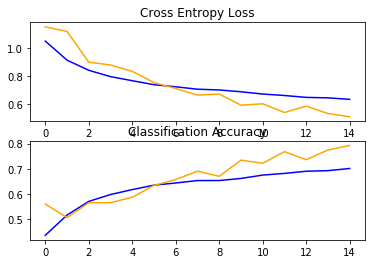

In [39]:
if __name__=="__main__":    
    # Добавим эпоху в имя файла (uses `str.format`)
    checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    # Создадим коллбек сохраняющий веса модели каждые 5 эпох
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        period=5)
    z, xData, yData, yData, yTest = AerialListFiles('C:\\Users\\seminaae\\Documents\\Python Scripts\\Inria\\NEW2-AerialImageDataset.zip')
    xTrain, xVal, yTrain, yVal = SplitTrainAndValidation(xData, yData)
    if True:
        trainGen = AerialDataGenerator(z, xTrain, yTrain)
        valGen = AerialDataGenerator(z, xVal, yVal, filesInBatch=1, cropsInFile=100)
        model = vgg_unet(2, input_height=128, input_width=128)
        print (type(model))
        print ("Compiling model")
        model.compile(optimizer="adadelta", loss='categorical_crossentropy', metrics=['accuracy'])
        model.save_weights(checkpoint_path.format(epoch=0))
        print ("Fitting model")
        history = model.fit_generator(
            trainGen,
			validation_data=valGen,
			validation_steps=50,
			epochs=15,
            callbacks=[cp_callback],
			workers=0
		)
        keras.models.save_model(model, 'aerial.h5')
        summarize_diagnostics([history])
    else:
        model = keras.models.load_model('aerial.h5')

# Предсказание

<ZipInfo filename='AerialImageDataset/train/images/austin1.tif' compress_type=deflate filemode='-rwxrwxrwx' external_attr=0x8020 file_size=75040370 compress_size=64810752>
<ZipInfo filename='AerialImageDataset/train/images/austin2.tif' compress_type=deflate filemode='-rwxrwxrwx' external_attr=0x8020 file_size=75040370 compress_size=65130411>
<ZipInfo filename='AerialImageDataset/train/images/austin3.tif' compress_type=deflate filemode='-rwxrwxrwx' external_attr=0x8020 file_size=75040370 compress_size=65124203>
<ZipInfo filename='AerialImageDataset/train/images/austin4.tif' compress_type=deflate filemode='-rwxrwxrwx' external_attr=0x8020 file_size=75040370 compress_size=65178622>
<ZipInfo filename='AerialImageDataset/train/images/austin5.tif' compress_type=deflate filemode='-rwxrwxrwx' external_attr=0x8020 file_size=75040370 compress_size=63830168>


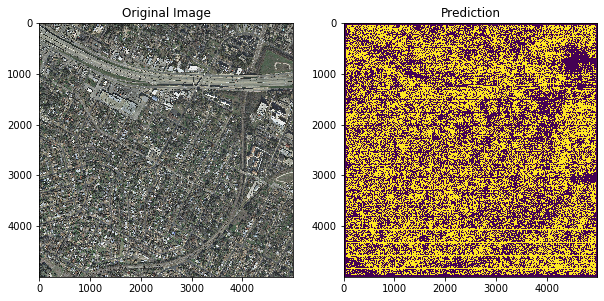

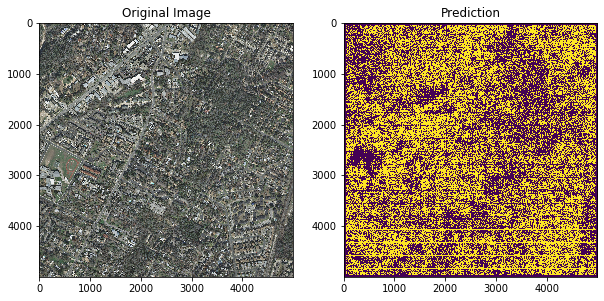

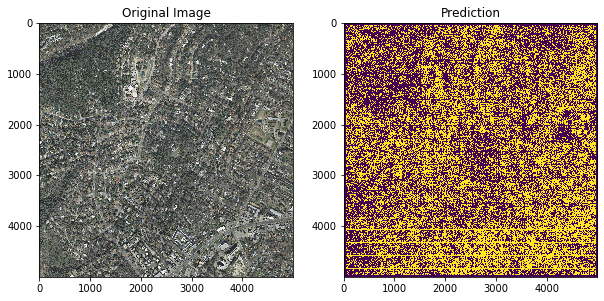

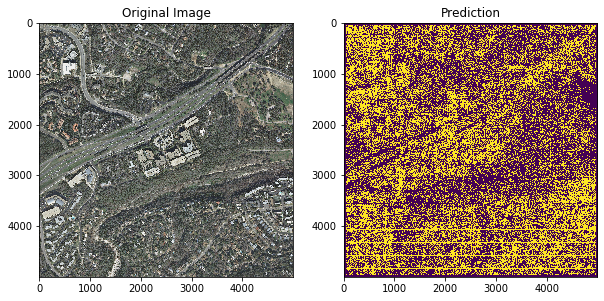

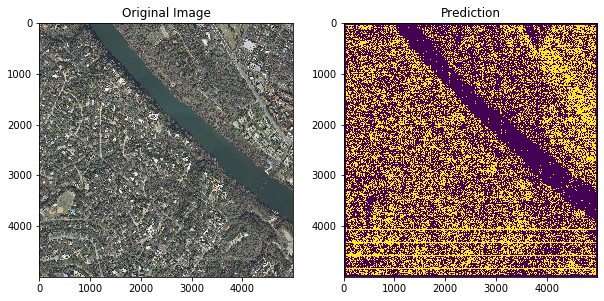

In [88]:
xVal1 = xVal[:5]
PredictOnImages(z, xVal1, model)